In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

sns.set(style="whitegrid")

In [2]:
# Load processed UNSW-NB15 dataset
df = pd.read_csv('../data/processed/unsw-nb15.csv')
print('Shape:', df.shape)
df.head()

Shape: (257673, 44)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
# Encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in ['attack_cat']]  # Exclude multiclass label for now
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Prepare X and y for binary classification
X = df.drop(['label', 'attack_cat'], axis=1, errors='ignore')
y = df['label']

# If 'label' is not 0/1, encode it
if y.dtype != int and y.dtype != float:
    y = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (206138, 42) Test shape: (51535, 42)


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Feature scaling complete.')

Feature scaling complete.


In [5]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    print(f'=== {name} ===')
    print('Accuracy:', results[name]['accuracy'])
    print('Precision:', results[name]['precision'])
    print('Recall:', results[name]['recall'])
    print('F1 Score:', results[name]['f1'])
    print('Confusion Matrix:\n', results[name]['confusion_matrix'])
    print('Classification Report:\n', results[name]['classification_report'])
    print('-' * 40)

=== Logistic Regression ===
Accuracy: 0.8980886775977491
Precision: 0.8853746136926803
Recall: 0.9655381812661302
F1 Score: 0.923720443850578
Confusion Matrix:
 [[14483  4117]
 [ 1135 31800]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     18600
           1       0.89      0.97      0.92     32935

    accuracy                           0.90     51535
   macro avg       0.91      0.87      0.89     51535
weighted avg       0.90      0.90      0.90     51535

----------------------------------------
=== Decision Tree ===
Accuracy: 0.9394974289317939
Precision: 0.9528843525015949
Recall: 0.9524214361621376
F1 Score: 0.952652838096395
Confusion Matrix:
 [[17049  1551]
 [ 1567 31368]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     18600
           1       0.95      0.95      0.95     32935

    accuracy                           0.9

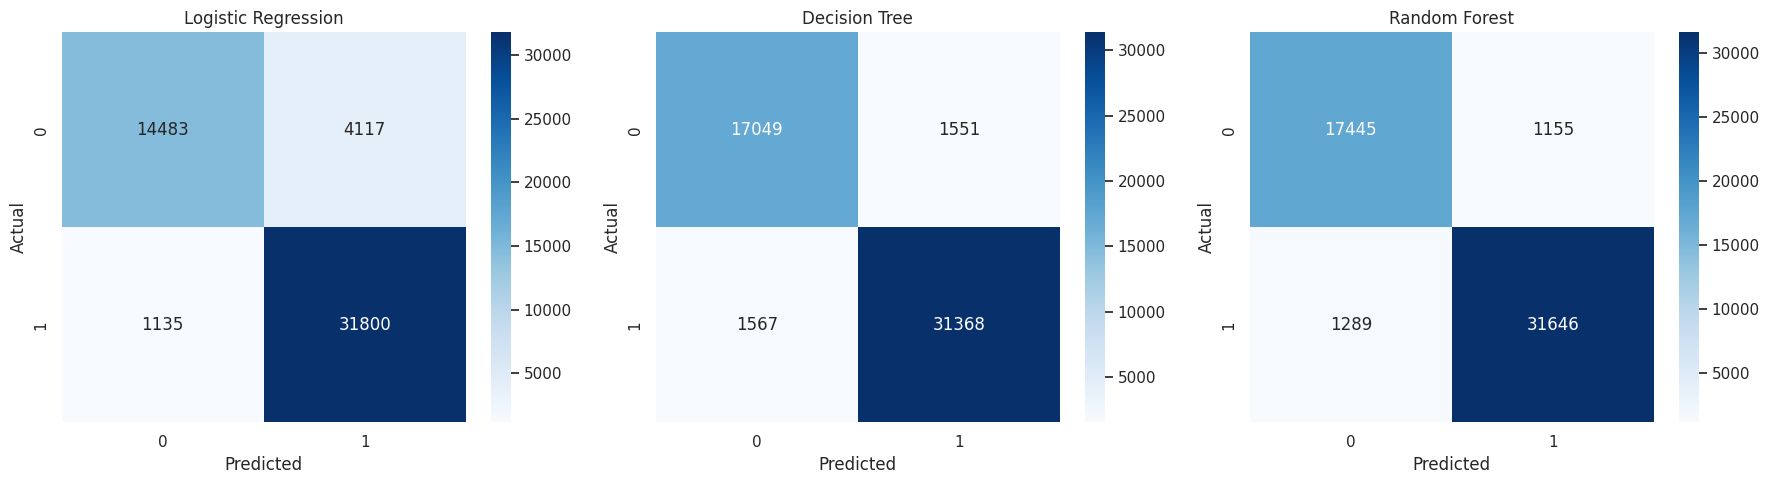

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [7]:
summary = pd.DataFrame({
    model: {
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1']
    }
    for model, res in results.items()
}).T
display(summary)

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.898089,0.885375,0.965538,0.923720
Decision Tree,0.939497,0.952884,0.952421,0.952653
Random Forest,0.952576,0.964788,0.960862,0.962821


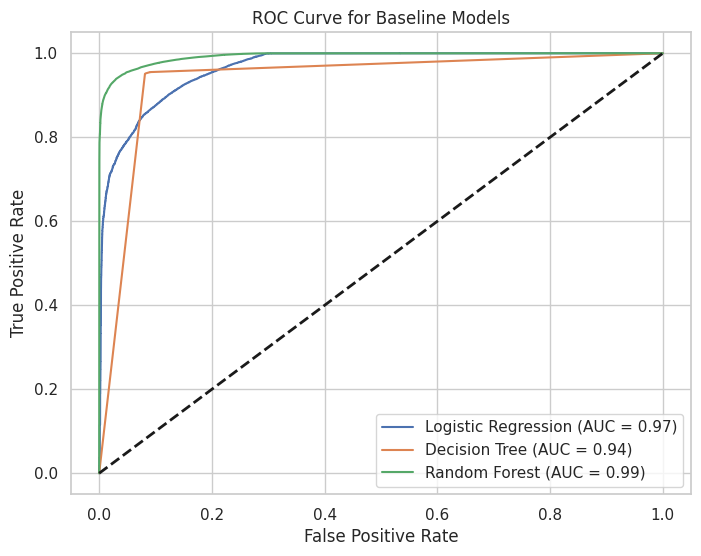

In [8]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba (e.g., some trees), use decision_function if available
        y_score = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baseline Models')
plt.legend(loc='lower right')
plt.show()

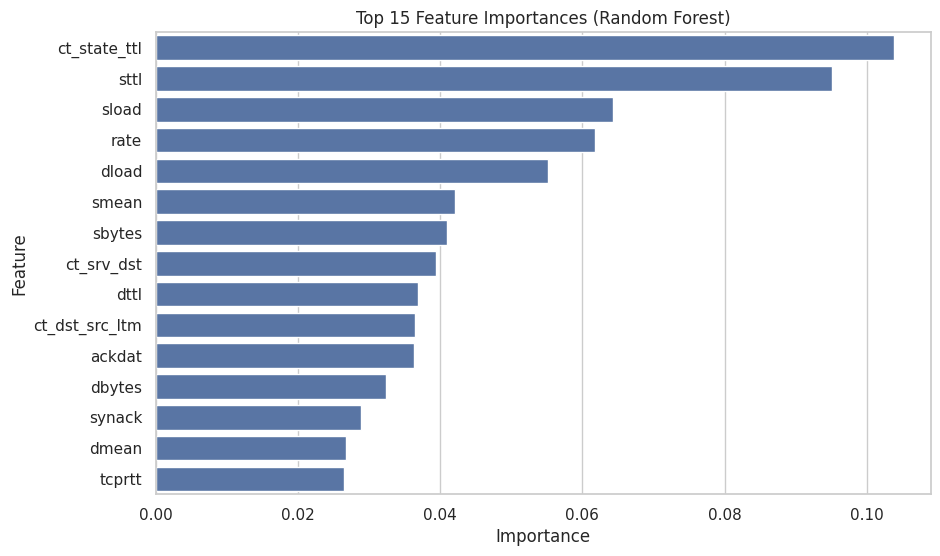

In [9]:
# Get feature importances from Random Forest
rf = models['Random Forest']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()